# wk6 Demo - Supervised Learning & Gradient Descent
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Summer 2018`__

In Supervised Machine Learning we use labeled training data to learn a decision function (a.k.a 'model') and make inferences about how well that decision function might perform when applied to new data. Of course the biggest factor that will determine the performance of your model is the quality of the data you train on. However another key challenge is the question of what models to consider & how to compare their performance so that you can choose the best one. Gradient Descent solves this challenge for a certain class of functions. By the end of this live session you should be able to:
* __... define__ the loss function for OLS Regression and its gradient.
* __... explain__ the relationship between model space and parameter space.
* __... recognize__ convex optimization problems and why they are desirable.
* __... describe__ the process of Gradient Descent & how it can be parallelized.
* __... contrast__ L1 and L2 regularization in terms of how they are implemented and how they impact our results.

**Note**: ...

# Introduction

In today's demo, we'll use Linear Regression as a simple example in order to explore key topics related to distributed learning of parametric models. Broadly speaking, the supervised learning of a parametric model can be split into to two components:
1. **Prediction Task**: Given an input vector, return an output value.
2. **Optimization Task (a.k.a. Learning)**: Given a strategy for making a prediction, return the specific parameters which guarantee the optimal prediction.

> __DISCUSSION QUESTION:__ _In the case of Linear Regression, which of the two tasks above are we most likely to want to parallelize? Why?_


OK, Let's start with a quick review of some notation you will have seen in w207. 

## Notation Review

Linear Regression tackles the __prediction task__ by assuming that we can compute our output variable, $y$, using a linear combination of our input variables. That is we assume there exist a set of **weights**, $\mathbf{w}$, and a **bias** term, $\mathbf{b}$, such that for any input $\mathbf{x}_j \in \mathbb{R}^m$:

\begin{equation}\tag{1.1}
y_j = \displaystyle\sum_{i=1}^{m}{w_i\cdot x_{ji} + b}
\end{equation}

In vector notation, this can be written:

\begin{equation}
y_j = \displaystyle{\mathbf{w}^T\mathbf{x}_{j} + b}
\end{equation}

Of course, this perfect linear relationship never holds over a whole dataset **$X$**, so Linear Regression attempts to fit (i.e. **learn**) the best line (in 1 dimension) or hyperplane (in 2 or more dimensions) to the data.  In the case of **ordinary least squares (OLS)** linear regression, best fit is defined as minimizing the Euclidean distances of each point in the dataset to the line or hyperplane.  These distances are often referred to as **residuals**. 

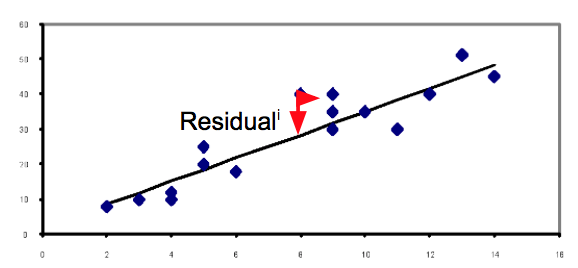

In [2]:
from IPython.display import Image
Image(filename="residual.png", width="400", height="200")

The calculation of the average residual (a.k.a.**mean squared error, MSE**) over our test or training set allows us to measure how good a fit we've achieved. We call this function the **loss** or **objective** function because our goal in the **optimization task** is to find the parameters which minimize it.

\begin{equation}\tag{1.2}
f(\mathbf{w}, b) = \frac{1}{n}\sum_{j=1}^{n}\left[ (\mathbf{w}^T\mathbf{x}_j + b) - y_i\right]^2,\\
n = \left|X_{\text{train}}\right|
\end{equation}

For convenience, we sometimes choose to think of the bias $b$ as weight $w_{m+1}$. To operationalize this, we'll _augment_ our input vectors by setting $x_{m+1}=1$. This gives us a simpler way to write the loss function:
$$
\mathbf{x}' :=
\begin{bmatrix}
\mathbf{x}\\
1
\end{bmatrix},\quad
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

Machine Learning packages like `sklearn` and `tensorflow` take this one step further by representing the entire training set in a single matrix were each row is an input vector and each column represents a feature:
$$
\text{X}' =
\begin{bmatrix}
\mathbf{x'}_1^{\text{T}}\\
\vdots\\
\mathbf{x'}_n^{\text{T}}
\end{bmatrix},\quad
\mathbf{y} = 
\begin{bmatrix}
y_1\\
\vdots\\
y_n
\end{bmatrix}
$$

\begin{equation}\tag{1.4}
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
\end{equation}

As you see here, it is customary to write loss as a function of the parameters $\theta$ (or equivalently $\mathbf{w}$ and $b$). However it is important to note that the MSE loss depends on both the parameters/weights  _and_ the data $X$, we'll talk more about that later.

> __DISCUSSION QUESTIONS:__ 
* _In equation 1.1 what do $x_{ji}$, $w_i$, and $\mathbf{w}$ each represent?_  
* _In the asynch's version of the loss function $\alpha$ and $\beta$ appear as parameters... what do they represent? How are they captured in equations 1.2 and 1.3 respectively?_ 
* _If we were computing loss over a really large data set what might be the arguments in favor / against using the augmented version of the loss function calculation?_

## Notebook Set Up

In [3]:
# general imports
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
# import helper modules
import helperFunc
import linRegFunc

# OPTIONAL - uncomment to print helper file docstrings
print(helperFunc.__doc__)
#print(linRegFunc.__doc__)


This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, models=[], names = [], title=None)
    plotErrorSurface(data, weight_grid, loss, title=None)




# A Small Example

We'll start with a small example of 5 2-D points:

In [5]:
%%writefile fivePoints.csv
1,2
3,4
5,5
4,3
2,3

Overwriting fivePoints.csv


In [6]:
# load data from file
points = np.genfromtxt("fivePoints.csv", delimiter=',')

Here's what they look like next to a the simplest possible linear model:  $ y = x$

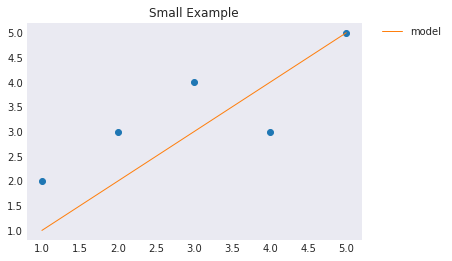

In [7]:
# easy plotting with a helper function
helperFunc.plot2DModels(points, [[1,0]],['model'], title = 'Small Example')

Looks reasonable, but its hard to gauge exactly how good a fit we have just by looking.

> __A TASK FOR YOU:__ Fill in the calculations below to compute the "Training Loss" for our data. These are easy and intuitive calculations that you will know from long-ago math classes... but instead of relying on your visual intuition, challenge yourself to think through these numbers in the context of our matrix equation for loss. Here it is again for your reference:
\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}


The parameter vector $\theta$ for our initial line $y=x$ is: 
$ \begin{bmatrix} ? \ \quad ? \ \end{bmatrix}$
         
The (augmented) data points $x_j$ are:
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$

Our loss calculations will be:

|$i$  | $y_i$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_i$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2$ |
|:---:|:-----:|:----------------:|:------------------------:|
|     | true y   |   predicted y   |  squared residual       |
| 1   |       |                  |             |
| 2   |       |                  |    |
| 3   |       |                  |    |
| 4   |       |                  |    | 
| 5   |       |                  |    | 

 The training loss $f(\boldsymbol{\theta})$ for this data and these weights is: _______
 

In [8]:
# Run this cell to confirm your Hand Calculations
X = helperFunc.augment(points)[:,:-1]
y = points[:,-1]
print("Loss:", linRegFunc.OLSLoss(X, y,[1,0]))

Loss: 0.8


 > __DISCUSSION QUESTIONS:__ 
 * _What parts of this computation could be parallelized? What, if any, aggregation has to happen at the end?_ 
 * _What key-value format, partitioning, sorting would help? Could you use a combiner?_ 
 * _In addition to the data stream, what other information would your map or reduce tasks need access to?_ 

## Demo: Random Parameter Search.

Ok, so we know the model looks ok and we know its loss is $0.8$ but is that any good? A naive approach to "learning" a Linear Model might be to randomly generate a few more models and then pick the model with the lowest loss. Let's try it.

Best Random Model: [0, 1], Loss: 0.8


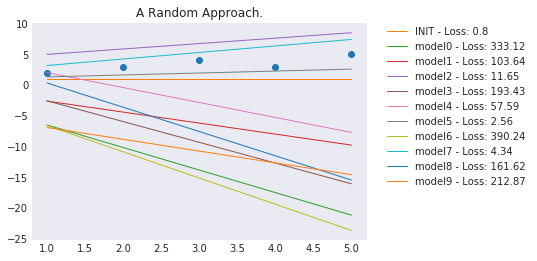

In [9]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
NUM_MODELS = 10
PARAM_RANGE = [-5,5]

#################### Random Search Demo ####################
# Load & pre-process data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

# "Training"
models = [[0,1]]
names = ["INIT - Loss: 0.8"]
best = {'loss':0.8, 'W': [0,1]}
for idx in range(NUM_MODELS):
    # initialize a random weight vector w/ values in specified range
    W = np.random.uniform(PARAM_RANGE[0],PARAM_RANGE[1], size=(2))
    # compute loss & store for plotting
    loss = linRegFunc.OLSLoss(X, y, W)
    models.append(W)
    names.append("model%s - Loss: %.2f" % (idx, loss))
    # track best model
    if loss < best['loss']:
        best['loss'] = loss
        best['W'] = W
        
# Display Results
print(f"Best Random Model: {best['W']}, Loss: {best['loss']}")
helperFunc.plot2DModels(points, models, names, "A Random Approach.")

So, that was pretty poor. One idea would be to run a lot more iterations.

> __DISCUSSION QUESTION:__ _To what extent could parallelization help us redeem this approach? What exactly would you parallelize?_

## Demo: Systematic Brute Force.

For obvious reasons a more systematic approach is desirable. Instead of randomly guessing, let's use what we know to search an appropriate section of the the model space.

We can tell from the data that the linear model should probably have a fairly shallow positive slope and a positive intercept between 0 and 2. So lets initialize every possible combination of weights in that range up to a granularity of, say $0.2$, and compute the loss for each one.

Searched 100 models...
Best model: [0.6 1.6], Loss: 0.31999999999999984


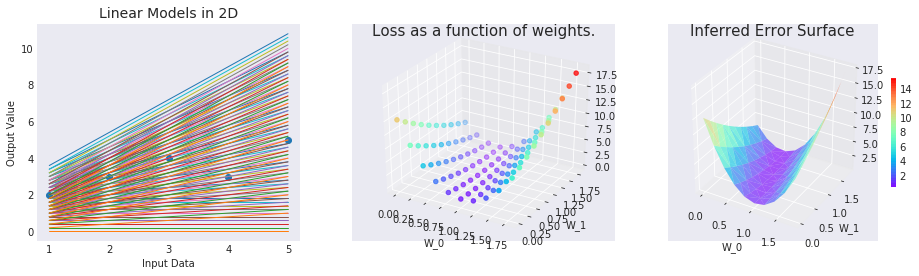

In [10]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
W0_MIN = 0
W0_MAX = 2
W0_STEP = 0.2

W1_MIN = 0
W1_MAX = 2
W1_STEP = 0.2

#################### Grid Search Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### "Training" 
# create a model for each point in our grid
grid = np.mgrid[W0_MIN:W0_MAX:W0_STEP,W1_MIN:W1_MAX:W1_STEP]
size = int(np.product(grid.shape)/2)
models = grid.reshape(2,size).T
# compute loss for each model
loss = []
for W in models:
    loss.append(linRegFunc.OLSLoss(X,y,W))
    
### Display Results
print(f"Searched {size} models...")
print(f"Best model: {models[np.argmin(loss)]}, Loss: {min(loss)}")
helperFunc.plotErrorSurface(points,models,loss)

> __DISCUSSION QUESTIONS:__ 
* _When we think about scaling up, is this still a better approach than guessing? How could it be parallelized?_ 
* _What would change about this approach if we had higher dimension data?_
* _In practice, when we're training Linear Models why don't we just look at the error surface and identify the lowest point?_
* _What about if we're training other kinds of models?_  

# Parameter Space, Gradients, and Convexity

As suggested by the systematic search demo, when we train parametric models we tend to switch back and forth between two different ways of visualizing our goal.

In [4]:
from IPython.display import HTML
HTML('<img src="./GD_gif/Gradient_Descent.gif">')

* When we look at a model next to our data represented in the Problem Domain Space, it is natural to think about loss as a measure of _**how far off the data are from our model**_. In other words, this visual suggests loss is a function of the training data $X$.
* By contrast, looking at an error surface plotted in Model Parameter Space, we intuitively see loss as an indicator of _**how far off the current model is from the optimal model**_. In other words, this view helps us think of loss as a function of the parameters $\theta$.

Of course in one sense, this distinction is just a matter of sematics. As we saw in equations 1.2, 1.3 and 1.4, MSE loss depends on _both_ the data and the parameters. However, in the context of 'inventing' ways to train a model, this distinction is a useful one. If we think of the data as fixed and focus on how loss varies _with respect to the parameters_, then we can take advantage of a little theory to speed up our search for the optimal parameters.

__Optimization Theory__

Calculus gives us the simple solution to optimizing a real function. The **First Order Conditions** (a.k.a. 'first derivative rule') says that the maximum or minimum of an unconstrained function must occur at a point where the first derivative = 0. In higher dimensions we extend this rule to talk about a **gradient** vector of partial derivatives which all must equal 0. 

When the first order partial derivatives are equal to zero, then we know we are at a local maximum or minimum of the real function.  But which one is it?  In order to tell, we must take the second derivatives of the real function.  If the second derivatives are positive at that point, then we know we are at a minimum.  If the second derivatives are negative, then we know we are at a maximum.  These are the **second order conditions.**

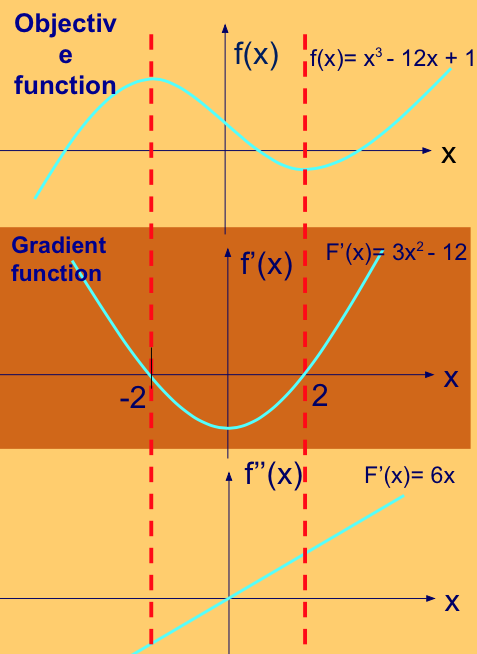

In [28]:
Image(filename="optimization.png", width="250", height="500")

__Convex Optimization__ is the lucky case where we know that the second derivatives never change sign. There are lots of complicated loss functions for which we can't easily visualize the error surface but for which we _can_ prove mathematically that this 2nd order condition is met. If this is the case, then we can think of the suface as _always curving up_ or _always curving down_ which guarantees that any minimum we reach will be an absolute minimum. 

> __DSICUSSION QUESTIONS:__ 
* _In the case of Linear Regression performed on data $X \in \mathbb{R}^m$, how many dimensions does the gradient vector have? What do each of the values in this vector represent visually?_
* _If we are systematically searching the parameter space for a lowest point, why might it be useful to know that our loss function is convex?_ 
* _In general (i.e. beyond Linear Regression) if finding the ideal parameters $\theta$, is as simple as solving the equation $f'(\theta)=0$, why don't we always train our models by solving that equation?_ 

## Demo: Gradient Descent

To take advantage of these lessons from Optimization Theory, we'll start by taking the derivative of the loss function with respect to the parameters $\boldsymbol{\theta}$. Recall the matrix formulation of our loss function:

\begin{equation}\tag{1.3}
f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\end{equation}

We can apply the sum and chain derivation rules to compute the gradient:

\begin{equation}\tag{3.1}
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'
\end{equation}

We _could_ now set this equation equal to $0$ and then solve for $\boldsymbol{\theta}$... but it turns out that this __closed form solution__ can be computationally challenging in higher dimensions. It also turns out that a simple approximation technique will work almost as well. 

The strategy of **Gradient Descent** is to start somewhere random in the Model Parameter Space and then move down the error surface to find a minimum point with the optimal parameters for our training data. Its ingeniousness is that we can do this without actually knowing the full shape of the error surface. Think of it like walking down a hill while blindfolded. You test each direction to see which way is down, then take a little step in that direction and repeat the process until you can't feel any more 'down' to go. The 'size' of our steps is controled by a hyperparameter, $\alpha$, the **learning rate**. The whole process can be summarized in 3 steps:
1. Initialize the parameters $\theta$.
2. Compute the gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$.
3. Update the parameters: $\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) $  

We repeat these steps until we reach a stopping criteria.

> __A TASK FOR YOU:__ Compute one Gradent Descent update step for the small example from Part 2. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  
> For your convenience the augmented input data vectors are already entered in the table below:


Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ |
|:----:|:-----:|:----------------:|:------------------------:|
|  input   | true y   |   predicted y   |  gradient  component for $x_j$       |
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             |
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    |
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    |

The gradient $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$ for this data and these weights is: _______

If $\eta = 0.1$ the update for this step will be: _______

The new parameters will be $\theta_{\text{new}}=$ _______  

 > __DISCUSSION QUESTIONS:__  
 * _How would you go about parallelizing this calculation? What would the mapper do, what would the reducers do? What key-value structure, sorting, partitioning, etc would you use?_ 
 * _How do the computational demands of performing GD compare to the task of computing the loss?_ 

__Run this demo to confirm your hand calculations & examine a few more GD steps.__

Model 0: [1.00, 0.00]
Loss: 0.8
     >>> gradient: [-0.8 -0.8]
     >>> update: [-0.08 -0.08]
Model 1: [1.08, 0.08]
Loss: 0.7872
     >>> gradient: [ 1.44 -0.16]
     >>> update: [ 0.144 -0.016]
Model 2: [0.94, 0.10]
Loss: 0.7918080000000005
     >>> gradient: [-1.632 -0.992]
     >>> update: [-0.1632 -0.0992]
Model 3: [1.10, 0.20]
Loss: 0.82701312
     >>> gradient: [2.5536 0.1856]
     >>> update: [0.25536 0.01856]
Model 4: [0.84, 0.18]
Loss: 0.9175584768000005
     >>> gradient: [-3.17568 -1.38368]
     >>> update: [-0.317568 -0.138368]
Model 5: [1.16, 0.32]
Loss: 1.1097440747520002

Searched 6 models...
Best model: [1.08 0.08], Loss: 0.7872


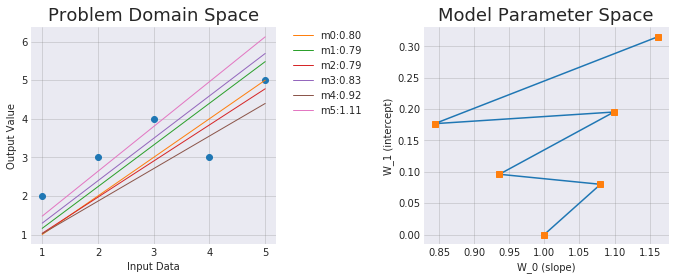

In [13]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
N_STEPS = 5
LEARNING_RATE = 0.1
ORIGINAL_MODEL = [1,0]
SHOW_CONTOURS = False

################### Gradient Update Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### Perform GD Update & save intermediate model performance
models, loss = linRegFunc.GDUpdate(X, y, N_STEPS,
                                   ORIGINAL_MODEL, 
                                   LEARNING_RATE, 
                                   verbose = True)

### Display Results
print(f"\nSearched {len(models)} models...")
print(f"Best model: {models[np.argmin(loss)]}, Loss: {loss[np.argmin(loss)]}")
linRegFunc.plotGDProgress(points, models, loss,
                          show_contours = SHOW_CONTOURS)

 > __DISCUSSION QUESTIONS:__  
 * _Look closely at the loss for each model, what problem do you notice?_ 
 * _Use the Model Parameter Space view to explain why this problem might be occurring._ __HINT:__ Try `SHOW_CONTOURS = True`. _Based upon your insights, propose a solution to this problem._
 * _When performing GD 'in the wild' will we be able to visualize the error surface (eg. using contour lines, heatmaps or 3D plots)?_

## Demo : Stoichastic Gradient Descent

In Full GD we do a descent step only after the calculation of the gradient over the whole set of data. In this case the gradient is precise and gives the best possible direction. But it can require quite a lot of time if we have huge amounts of data. 

In practice we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it.

\begin{equation}\tag{3.2}
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
\end{equation}

where $a_i$ is an array of indices of objects which are in this batch. Common approach here that you should use is to shuffle samples randomly and then iterate over them with batches.

So with this batch approach we get an approximation of the real gradient in point $\boldsymbol{\theta}$. This approximation is very cheap and fast to compute (usually $B$ is not too big $-$ from 32 to 256). After obtaining this gradient we do a descent step in this approximate direction and proceed to the next stage of batch descent.

> __A TASK FOR YOU:__ Perform 5 update steps of Stoichastic Gradient Descent with batchsize = $1$ on our small data set. 
Recall that our initial parameters were:
$$ \boldsymbol{\theta} = \begin{bmatrix} 1 \ \quad 0 \ \end{bmatrix}$$  
> ... and we used a learning rate of $\boldsymbol{\eta} = 0.1$

Hand Calculations:

|  $x_j '$  | $y_j$ |   $\boldsymbol{\theta}\cdot\mathbf{x}'_j$ | $\frac{2}{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_j - y_j\right]\cdot\mathbf{x}'_j$ | $\eta \nabla_{\boldsymbol{\theta}} f$ | $\boldsymbol(\theta) - \eta \nabla_{\boldsymbol{\theta}} f $ |
|:----:|:-----:|:----------------:|:------------------------:|:--------------:|:-----------:|
|  input   | true y   |   predicted y   | gradient for this 'batch' | update | new parameters|
| $ \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   |  2   |                  |             | | |
| $ \begin{bmatrix} 3 \\ 1 \\ \end{bmatrix}$   |  4   |                  |    |  |  |
| $ \begin{bmatrix} 5 \\ 1 \\ \end{bmatrix}$   |  5   |                  |    |  |  |
| $ \begin{bmatrix} 4 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |  |  |
| $ \begin{bmatrix} 2 \\ 1 \\ \end{bmatrix}$   |  3   |                  |    |  |  |

 > __DISCUSSION QUESTIONS:__  
 * _How does this result compare to our result from the hand calculations in the last section? What implications does this have for our quest to find the optimal paramters?_ 
 * _How will parallelizing Stoichastic Gradient Descent be similar/different to parallelizing regular GD?_ 

Model 0: [1.00, 0.00]
Loss: 0.8
     >>> gradient: [-0.4 -0.4]
     >>> update: [-0.04 -0.04]
Model 1: [1.04, 0.04]
Loss: 0.7648
     >>> gradient: [-1.008 -0.336]
     >>> update: [-0.1008 -0.0336]
Model 2: [1.14, 0.07]
Loss: 0.9141452800000004
     >>> gradient: [1.5552  0.31104]
     >>> update: [0.15552  0.031104]
Model 3: [0.99, 0.04]
Loss: 0.7782153256960003
     >>> gradient: [1.5737856 0.3934464]
     >>> update: [0.15737856 0.03934464]
Model 4: [0.83, 0.00]
Loss: 1.2577106818564097
     >>> gradient: [-1.07283661 -0.5364183 ]
     >>> update: [-0.10728366 -0.05364183]
Model 5: [0.94, 0.06]
Loss: 0.8337672467910437

Searched 6 models...
Best model: [1.04 0.04], Loss: 0.7648


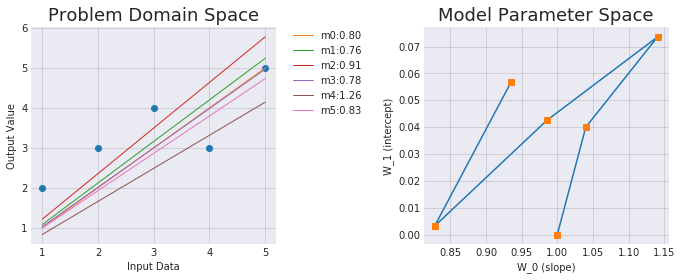

In [18]:
import helperFunc, linRegFunc

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
N_STEPS = 5
BATCHSIZE = 1
LEARNING_RATE = 0.1
ORIGINAL_MODEL = [1,0]
SHOW_CONTOURS = False

################### Stoichastic GD Demo #################### 
### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = helperFunc.augment(points)[:,:2]
y = points[:,1]

### Perform SGD Updates & save intermediate model performance
models, loss = linRegFunc.SGDUpdate(X, y, N_STEPS,
                                    BATCHSIZE,
                                    ORIGINAL_MODEL, 
                                    LEARNING_RATE, 
                                    verbose = True)

### Display Results
print(f"\nSearched {len(models)} models..." %())
print(f"Best model: {models[np.argmin(loss)]}, Loss: {loss[np.argmin(loss)]}")
linRegFunc.plotGDProgress(points, models, loss,
                          show_contours = SHOW_CONTOURS)

> __DISCUSSION QUESTIONS:__ 
* _At first glance does this seem to work as well as regular gradient descent? Why might our initial impression be deceiving?_ 
* _Does adjusting the batchsize and/or learning rate fix the problem that we're seeing?_
* _What do you notice about the direction of the first 3 updates? From the perspective of the first three points, what should our line look like?_
* _How does the scale of our data can impact the direction of our updates & time to convergence?_

# A Bigger Example

Ok, now that we have a handle on the math and the basic design choices involved in implementing & parallelizing Gradient Descent. Lets look at a slightly bigger example: the boston housing prices dataset.

In [19]:
# ML modules
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

/opt/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
# set style for plotting
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [21]:
# we'll also fix the random see for reproducibility
np.random.seed(42)

## Boston House Prices Dataset

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn. Run the next few cells to load the data and become familiar with it.

In [22]:
# Load the data & take a look.
from sklearn.datasets import load_boston
boston = load_boston()

In [23]:
# OPTIONAL - view description
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [24]:
# Create data frame & test/train split.
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Take a look
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Exploratory Data Analysis

Before we jump into our linear regression, its good to become familiar with the variables you will be modeling.

In [26]:
# Summary statistics
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Note that some of the features are catecorical and some are continious.

Let's also take a look at a correlation matrix of features.

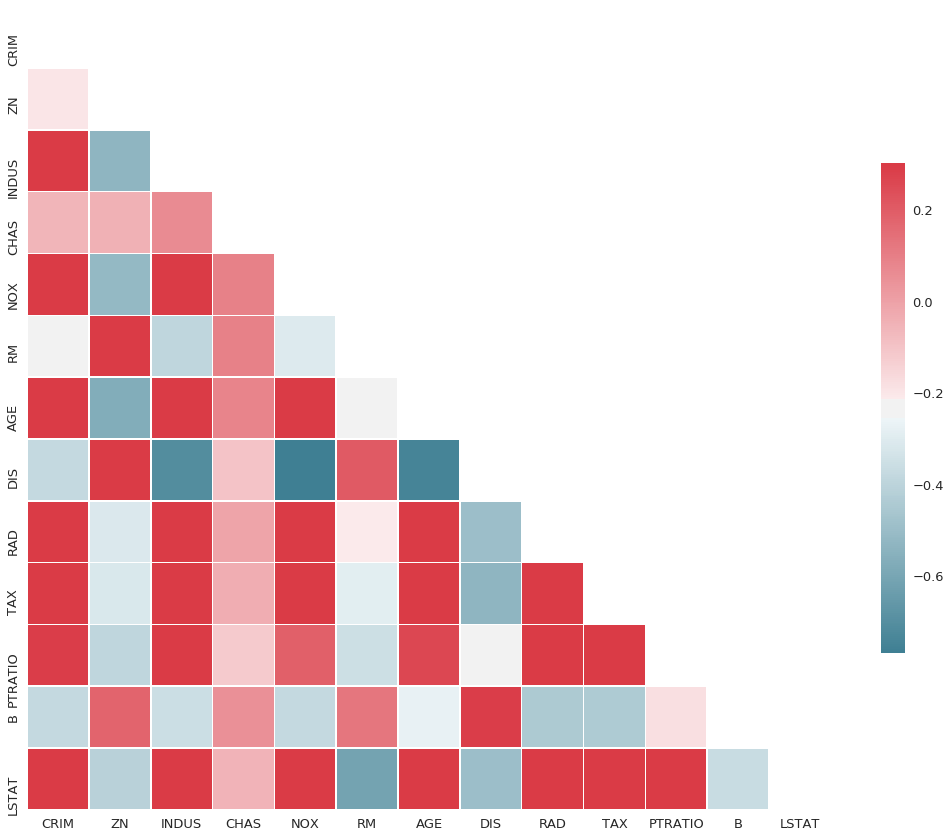

In [27]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

## Scaling

Once we start performing gradient descent on real world data, a few additional concerns arise. 

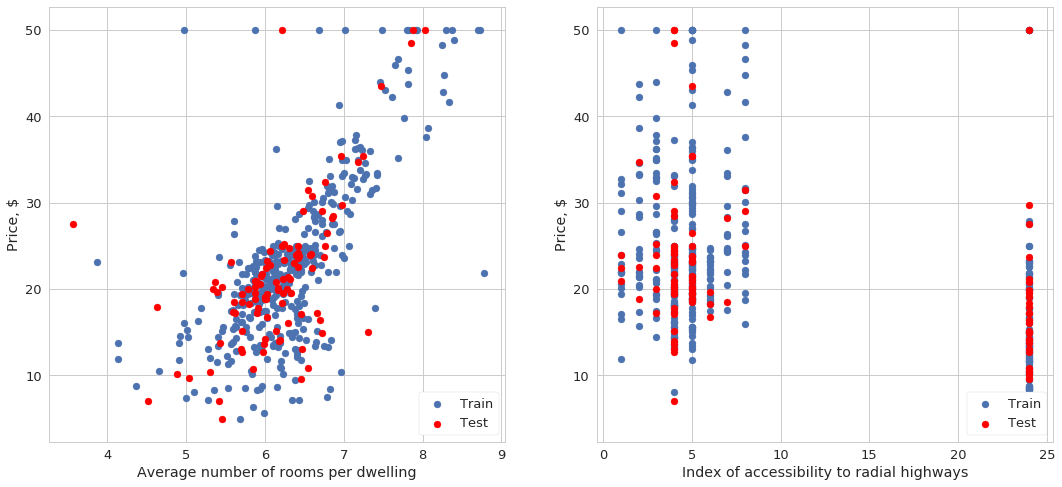

In [29]:
# Lets visualize two of the features from the Boston Dataset
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right")
plt.show()

> __DISCUSSION QUESTION:__ What will happen in the Gradient Descent update step when you have input variables that are measured on very different scales? What could we do to avoid this problem?

As you probably realized, the easiest solution is to perform normalization before we start modeling. Here we'll normalize each feature so that all $x_{ji} \in (0,1)$.

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training. However once we've got our normalization functions, we'll also aply them to the test set.

In [31]:
X_test = scaler.transform(X_test)

# Sklearn Linear Regression

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

## Fitting

In [32]:
# initialize the model
model_sk = LinearRegression()

# fit the data
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
# run our model to predict the test and train sets for evaluation
preds_test = model_sk.predict(X_test)
preds_train = model_sk.predict(X_train)

## Evaluation

Let's see what features are significant for the model

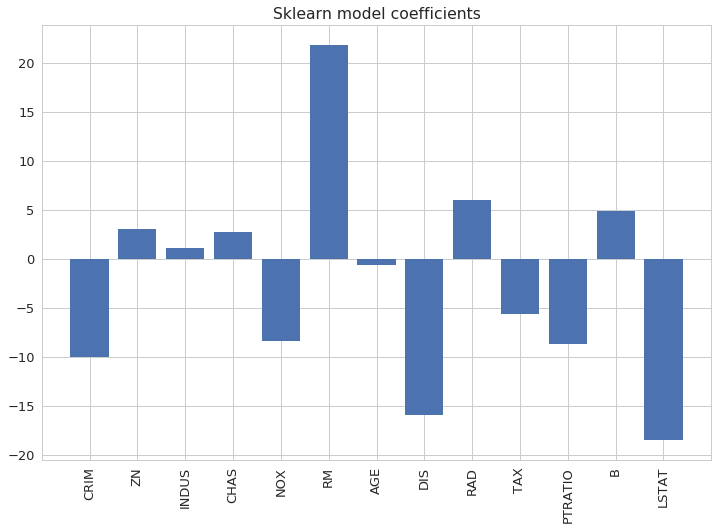

In [34]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]), model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients")
plt.show()

Next we'll evaluate our model according to three different metrics: 
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

Note that there is no MAPE implementation in sklearn & that this is a problematic metric because it is prone to ZeroDivisionErrors. However for today's illustration we have included a custom implementation in the supplemental file `linRegFunc.py`. 

In [35]:
# define a function
def evaluate(models, metrics, samples, metrics_names, models_names):
    """
    This function runs Linear Regression Evaluation metrics 
    by looping over a provided set of models and datasets.
    """
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

In [36]:
# define metrics to run
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           linRegFunc.mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

# define data sets & models to run on
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]
models = [model_sk]

In [37]:
# function call
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585


It also interesting to take a look how the predicted points relate to real ones. All the points should lie on the black dotted line ($y=x$) assuming that our model is perfect.

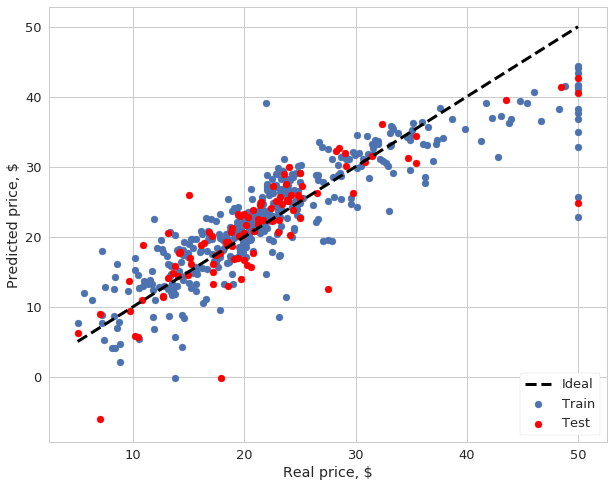

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(y_train, preds_train, label="Train")
plt.scatter(y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right")
plt.show()

## Cross-validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [39]:
cv = KFold(n=len(X), n_folds=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Scale
* Train
* Evaluate

And store the average value of the errors ($\text{res}$ variable)

In [40]:
res = None
for train_idx, test_idx in cv:
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    else:
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
# take the average value across all folds
res /= cv.n_folds

Here is the result of CV

In [41]:
res

,MAE,RMSE,MAPE
Sklearn CV Train,3.269853,4.660627,16.423244
Sklearn CV Test,3.390748,4.843271,17.026372


# Homegrown Linear Regresssion

In this section we'll write our own Linear Regression class that performs gradient descent. This class will use numpy for efficient matrix calculations. Recall that the matrix representation of our loss functions is: 

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
$$

Then the gradient can be easily calculated in vectorized form:

$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\text{X}'^{\text{T}}\left(\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\right)
$$

Exactly these computations are implemented down below in **BasicLinearRegressionHomegrown** class

In [42]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.0005):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

__Create model__

In [43]:
model_homegrown = BasicLinearRegressionHomegrown()

__Fitting__

In [44]:
model_homegrown.fit(X_train, y_train, max_iter=40000)

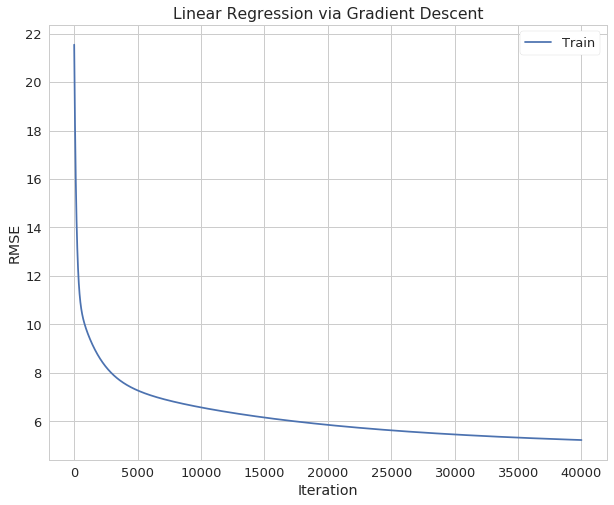

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend()
plt.show()

__Evaluation__

In [46]:
models = [model_sk, model_homegrown]
models_names = ["Sklearn", "Homegrown"]

In [47]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.553939,5.215440,16.997004
Homegrown Test,3.163314,5.182396,16.636239


## Numerical check
In the last section **BasicLinearRegressionHomegrown** class provides you with the method *_grad* that allows to compute analytical gradient. This function is correct. However with more complicated Loss Functions we may run the risk of making a mistake. In this section we'll look at a simple way to check that our gradient function is right.

The formula for analytical gradient (from calculus):

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

The next class, **TweakedLinearRegressionHomegrown**, inherits from **BasicLinearRegressionHomegrown** and adds a method for numerical approximation of gradient. Next we'll 
* Check our approximation function by comparing with the analytical one. They **should** be similar.
* Plot the difference of analytical and numerical gradients and describe what we observe.

In [48]:
class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
        
    @staticmethod
    def _gradient_approximation(f, x):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input 
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates 
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        alpha = 0.001
        for i in range(len(x)):
            h = np.zeros(len(x))
            h[i] += alpha
            grad_num[i] = (f(x + h) - f(x)) / alpha

        return grad_num
    
    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression 
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """
        
        grad_num = np.zeros(X.shape[1])
        
        def f(a):
            pred = np.dot(X, a)
            error = pred - y
            mse = np.mean(error ** 2)
            return mse
            
        
        grad_num = self._gradient_approximation(f, self._theta)
        
        return grad_num
    
    def _gd(self, X, y, max_iter, alpha=0.001):
        """
        Runs GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)
            
            self._theta -= alpha * grad

Create model

In [49]:
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()

Fitting

In [50]:
model_homegrown_check_grad.fit(X_train, y_train, max_iter=40000)

Plotting error curves

In [51]:
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])

In [52]:
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)

In [53]:
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.

In [54]:
pd.DataFrame(absolute_error(grad, grad_num)).describe()

,0
count,4.000000e+04
mean,2.599855e-06
std,3.591395e-14
min,2.599855e-06
25%,2.599855e-06
50%,2.599855e-06
75%,2.599855e-06
max,2.599856e-06


In [55]:
absolute_error(grad, grad_num)[:2]

array([2.59985569e-06, 2.59985539e-06])

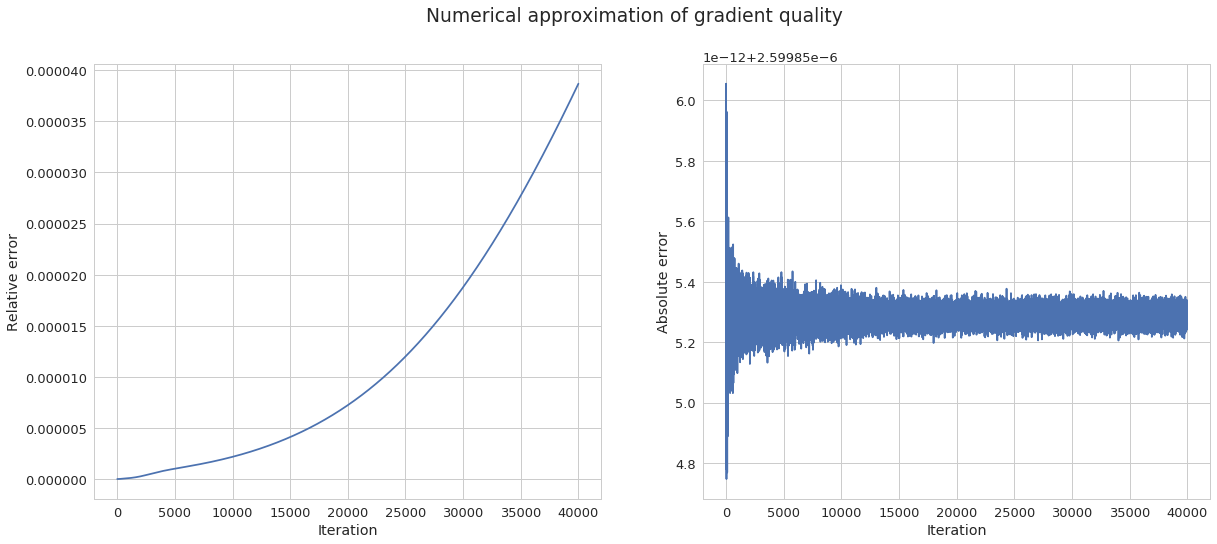

In [56]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

As one can observe absolute error jitters but remains approximately the same during all the trining process. The big values in the beginning is due to the fact that the values of gradient is also big.

Relative error grows because the norm of the gradient (which is in the denominator) becomes smaller while the optimization process converges.

## Stochastic Gradient Descent

In section 3 we suggested that we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it. However with our small dataset this didn't seem to be the case. Let's take a second look now that we are working on a more realistic dataset.

Recall the gradient calculation for Stoichastic Gradient Descent:

\begin{equation}\tag{3.2}
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
\end{equation}

where $a_i$ is an array of indices of objects which are in this batch. 

The next class **StochasticLinearRegressionHomegrown**, inherits from **TweakedLinearRegressionHomegrown** to stochastic gradient descent algorithm as a member of a class. As before, we'll check that analytical gradient is right via numerical gradient function from **TweakedLinearRegressionHomegrown**.

In [57]:
class StochasticLinearRegressionHomegrown(TweakedLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(StochasticLinearRegressionHomegrown, self).__init__()
    
    def _sgd(self, X, y, max_iter, batch_size, alpha=0.0005):
        """
        Runs Stochastic GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        
        for epoch in range(max_iter):
            idxs = np.random.permutation(X.shape[0])
            X = X[idxs]
            y = y[idxs]
            for i in range(0, len(X), batch_size):
                
                self.history["coef"].append(self._theta[1:].copy())
                self.history["intercept"].append(self._theta[0].copy())
                
                rmse = self.score(X, y)
                self.history["cost"].append(rmse)
                
                # calculate gradient
                grad = self._grad(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad"].append(grad)
                
                # numerical gradient
                grad_num = self._grad_num(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad_num"].append(grad_num)
            
                # do gradient step
                self._theta -= alpha * grad
        
    def fit(self, X, y, max_iter=1000, batch_size=16):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        self._sgd(X, y, max_iter, batch_size)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

Create model

In [58]:
model_homegrown_sgd = StochasticLinearRegressionHomegrown()

Fitting

In [59]:
model_homegrown_sgd.fit(X_train, y_train, max_iter=1500)

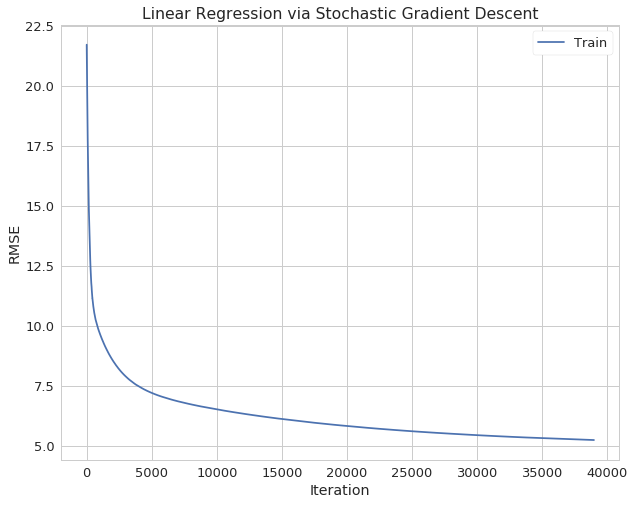

In [60]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_sgd.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Stochastic Gradient Descent")
plt.legend(frameon=True)
plt.show()

Plotting error curves

In [61]:
grad_num = np.array(model_homegrown_sgd.history["grad_num"])
grad = np.array(model_homegrown_sgd.history["grad"])

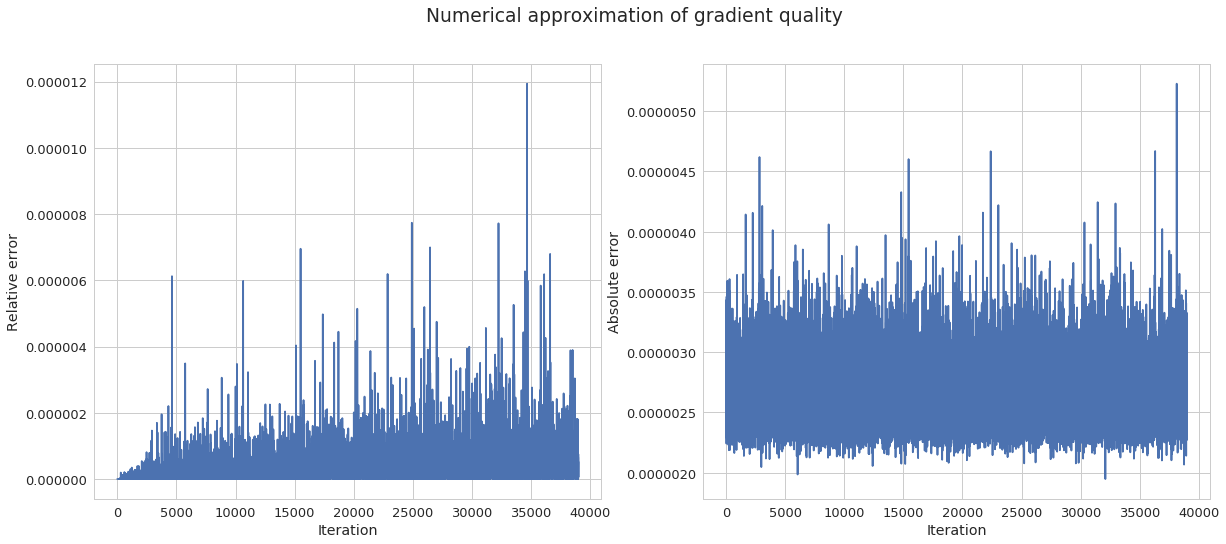

In [62]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

Evaluation

In [63]:
models = [model_sk, model_homegrown, model_homegrown_sgd]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown SGD"]

In [64]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,3.553939,5.215440,16.997004
Homegrown Full GD Test,3.163314,5.182396,16.636239
Homegrown SGD Train,3.551185,5.217781,16.970106
Homegrown SGD Test,3.178549,5.192256,16.741535


## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity. It allows us to avoid overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

The class below, **RegularizedLinearRegressionHomegrown**, inherits from 
**BasicLinearRegressionHomegrown** and encorporates both regularization strategies into the GD solution of Linear Regression. Below we'll examine the problem that arises with L1-regularization as well as its benefits.

In [65]:
class RegularizedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        # call the constructor of the parent class
        super(RegularizedLinearRegressionHomegrown, self).__init__()
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function 
        with L1 and L2 regularizations

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        # penalties only for weights
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient

Create model

In [66]:
model_homegrown_regularized_l2 = RegularizedLinearRegressionHomegrown(l1_reg=0.0, l2_reg=0.1)
model_homegrown_regularized_l1 = RegularizedLinearRegressionHomegrown(l1_reg=1.0, l2_reg=0.0)

Fitting

In [67]:
model_homegrown_regularized_l2.fit(X_train, y_train, max_iter=40000)
model_homegrown_regularized_l1.fit(X_train, y_train, max_iter=40000)

Evaluation

In [68]:
models = [model_sk, model_homegrown, model_homegrown_regularized_l2, model_homegrown_regularized_l1]
models_names = ["Sklearn", "Homegrown", "Homegrown Regularized L2", "Homegrown Regularized L1"]

In [69]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.553939,5.215440,16.997004
Homegrown Test,3.163314,5.182396,16.636239
Homegrown Regularized L2 Train,4.538807,6.663758,21.517049
Homegrown Regularized L2 Test,3.895744,5.969197,20.338186
Homegrown Regularized L1 Train,4.463647,6.509919,21.737358
Homegrown Regularized L1 Test,3.905801,6.069943,20.587212


Comparison of regularized models

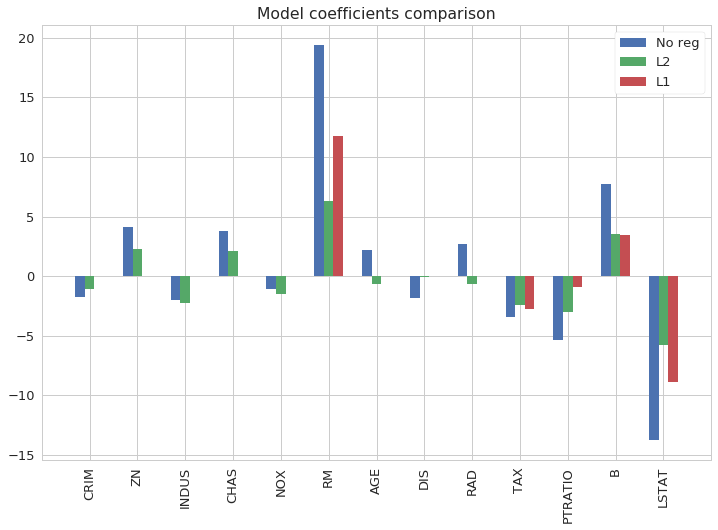

In [70]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_homegrown.coef_.shape[0]) - 0.2, model_homegrown.coef_, width=0.2, label="No reg")
plt.bar(np.arange(model_homegrown_regularized_l2.coef_.shape[0]), model_homegrown_regularized_l2.coef_, width=0.2, label="L2")
plt.bar(np.arange(model_homegrown_regularized_l1.coef_.shape[0]) + 0.2, model_homegrown_regularized_l1.coef_, width=0.2, label="L1")
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Model coefficients comparison")
plt.legend()
plt.show()

In [71]:
print("2-norm of weights:\n")
print("{:10s}{:.2f}".format("No reg:", np.linalg.norm(model_homegrown.coef_)))
print("{:10s}{:.2f}".format("L2:", np.linalg.norm(model_homegrown_regularized_l2.coef_)))
print("{:10s}{:.2f}".format("L1:", np.linalg.norm(model_homegrown_regularized_l1.coef_)))

2-norm of weights:

No reg:   26.86
L2:       10.92
L1:       15.43


In [56]:
print("Number of non-zero coefficients:\n")
print("{:10s}{:d}".format("No reg:", np.sum(np.abs(model_homegrown.coef_) > 1e-2)))
print("{:10s}{:d}".format("L2:", np.sum(np.abs(model_homegrown_regularized_l2.coef_) > 1e-2)))
print("{:10s}{:d}".format("L1:", np.sum(np.abs(model_homegrown_regularized_l1.coef_) > 1e-2)))

Number of non-zero coefficients:

No reg:   13
L2:       13
L1:       5


As one can notice L2-regularization greatly reduces the 2-norm of weight vector thereby it prevents overfitting. Regularization constant can be used to control [bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).

L1-regularization plays the same role but it also has one very important prorepty: it can work as a feature selector (impose sparsity on the coefficient vector). From mathematical perspective it can be explained as follows: L1-norm is the "closest" approximation to the L0-norm which explicitly equals to the number of non-zero elements. For sure, the ideal feature selector is L0-norm but one can not simply minimize it because of its computationally intractability (due to its combinatorial nature). Thus people usually use L1-norm for that purpose. More intuitive geometrical interpretation can be found [here](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2) or in any other source (lots of them). For more detailed and deep mathematical explanation one can take a look into [compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing) method introduced by Terence Tao and David Donoho in the early 2000's.